In [16]:
# dataset is from https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
import plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object
from sklearn.metrics import mean_squared_error
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
#plt.style.use('ggplot') # style of plots. ggplot is one of the most used style, I also like it.

In [2]:
train = pd.read_csv("./input/DailyDelhiClimateTrain.csv")
test = pd.read_csv("./input/DailyDelhiClimateTest.csv")
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
print(train.shape, test.shape)

(1462, 5) (114, 5)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
date            1462 non-null datetime64[ns]
meantemp        1462 non-null float64
humidity        1462 non-null float64
wind_speed      1462 non-null float64
meanpressure    1462 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
date            114 non-null datetime64[ns]
meantemp        114 non-null float64
humidity        114 non-null float64
wind_speed      114 non-null float64
meanpressure    114 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.6 KB


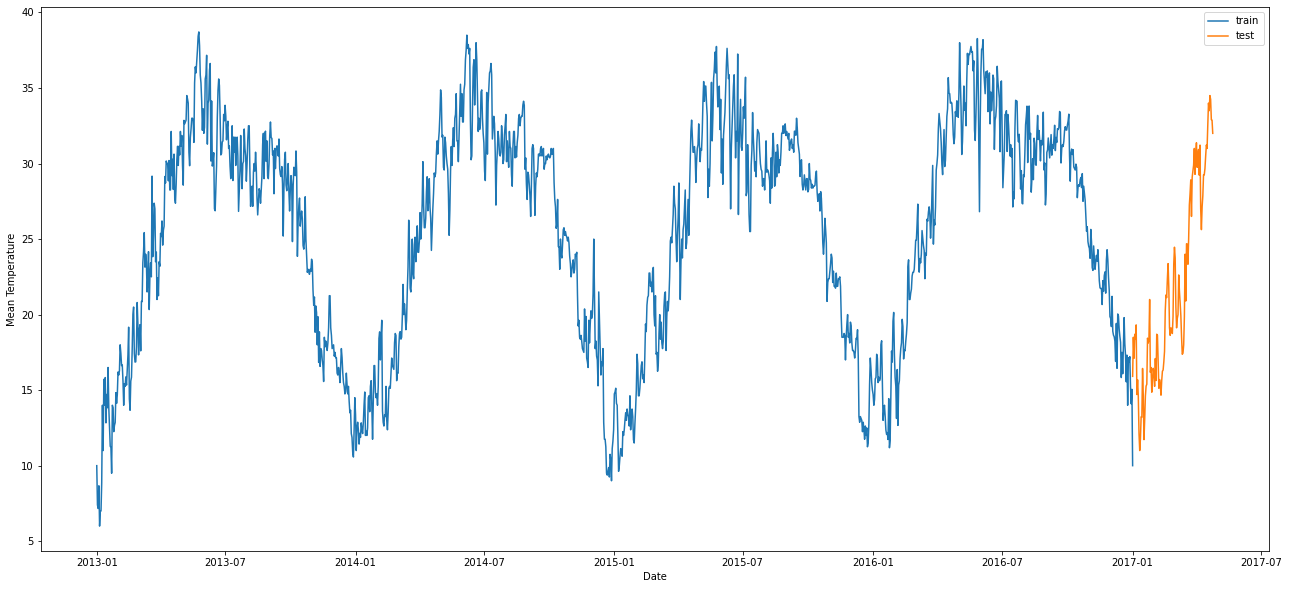

In [5]:
plt.figure(figsize=(22,10))
plt.plot(train.date, train.meantemp, '-', label='train')
plt.legend()

plt.plot(test.date, test.meantemp, '-', label='test')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [6]:
time_train=train.loc[:, ["date", "meantemp"]]
time_train.index = time_train.date
time_train.drop("date",axis=1, inplace=True)

time_test=test.loc[:, ["date", "meantemp"]]
time_test.index = time_test.date
time_test.drop("date",axis=1, inplace=True)
time_train.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


# Check statinary

In [7]:
from statsmodels.tsa.stattools import adfuller
#utility functions
def check_adfuller(ts):
    
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
    
def check_mean_std(ts):
    
    rolmean = ts.rolling( window=6).mean()
    
    rolstd = ts.rolling(window=6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    

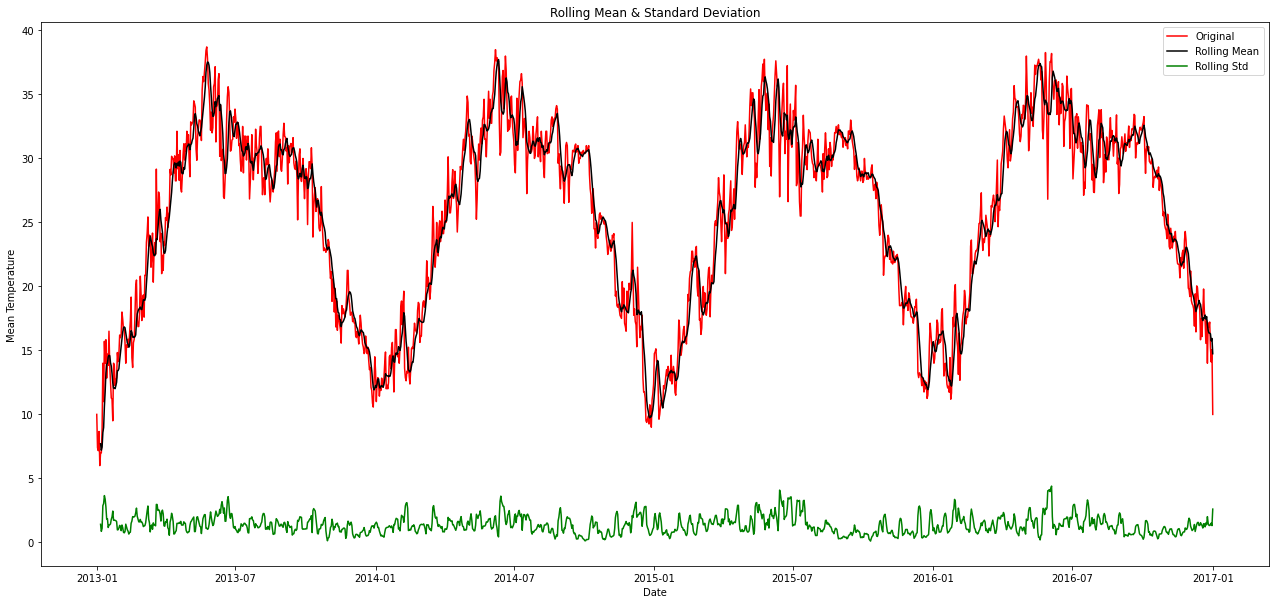

Test statistic:  -2.0210690559206728
p-value:  0.27741213723016056
Critical Values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


In [8]:
check_mean_std(time_train)
check_adfuller(time_train.meantemp)

# removeing trend

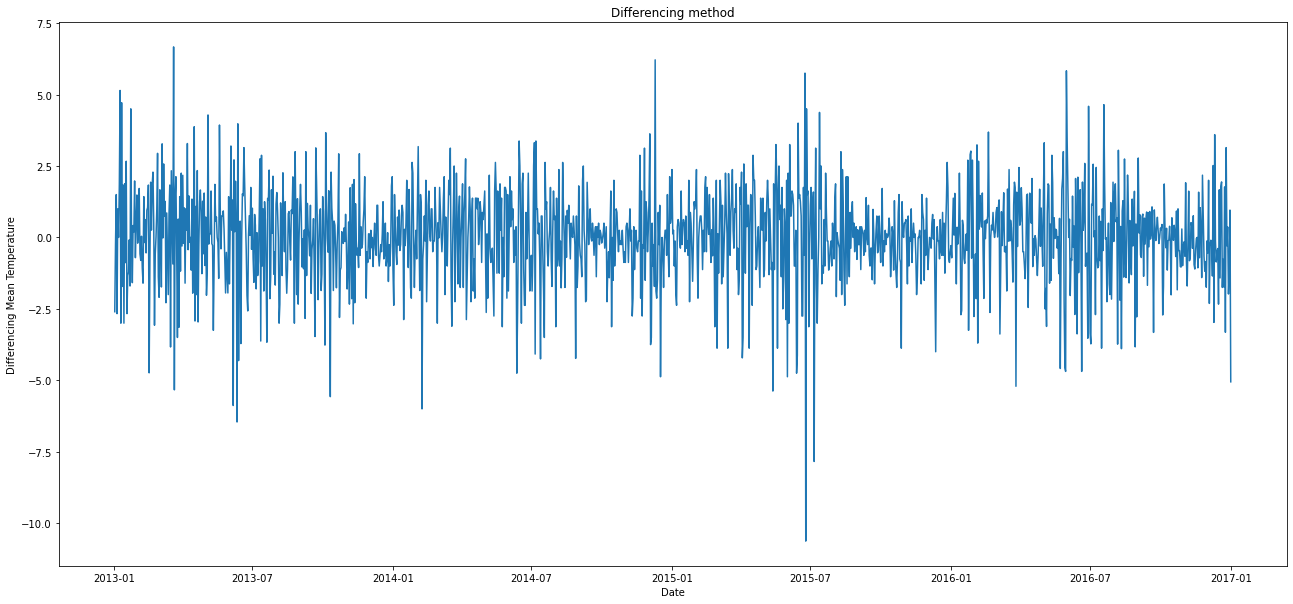

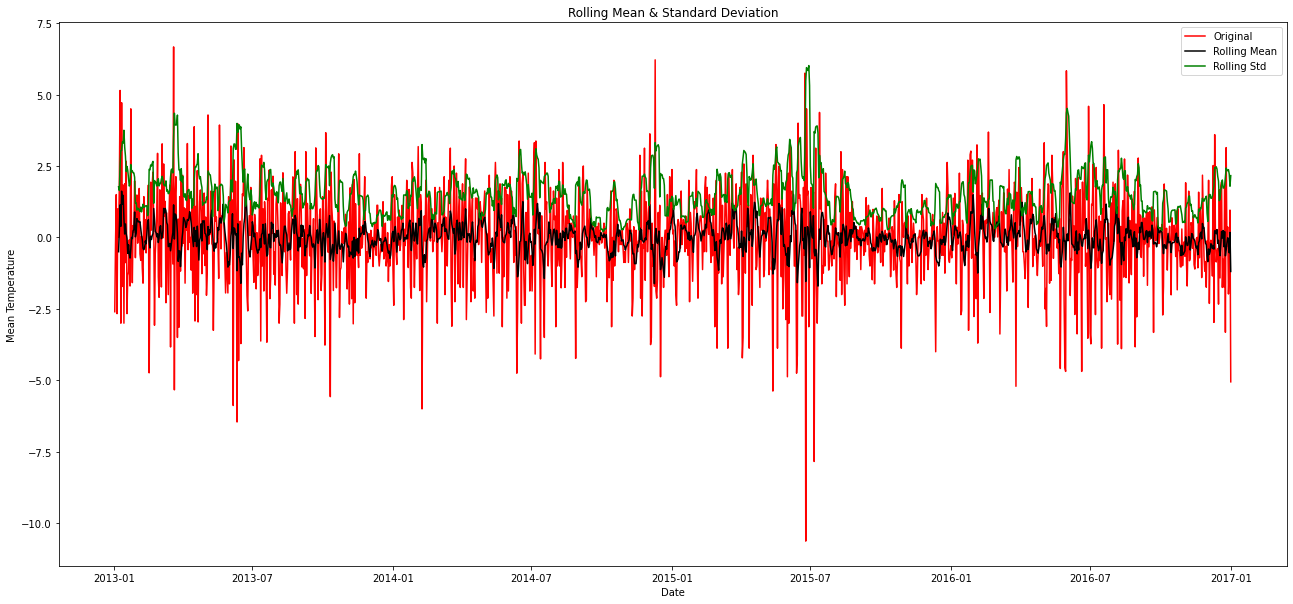

Test statistic:  -16.3787202670747
p-value:  2.7648631375945265e-29
Critical Values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


In [9]:

train_diff = time_train - time_train.shift()
plt.figure(figsize=(22,10))
plt.plot(train_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()
train_diff.dropna(inplace=True)
# check stationary
check_mean_std(train_diff)
check_adfuller(train_diff.meantemp)

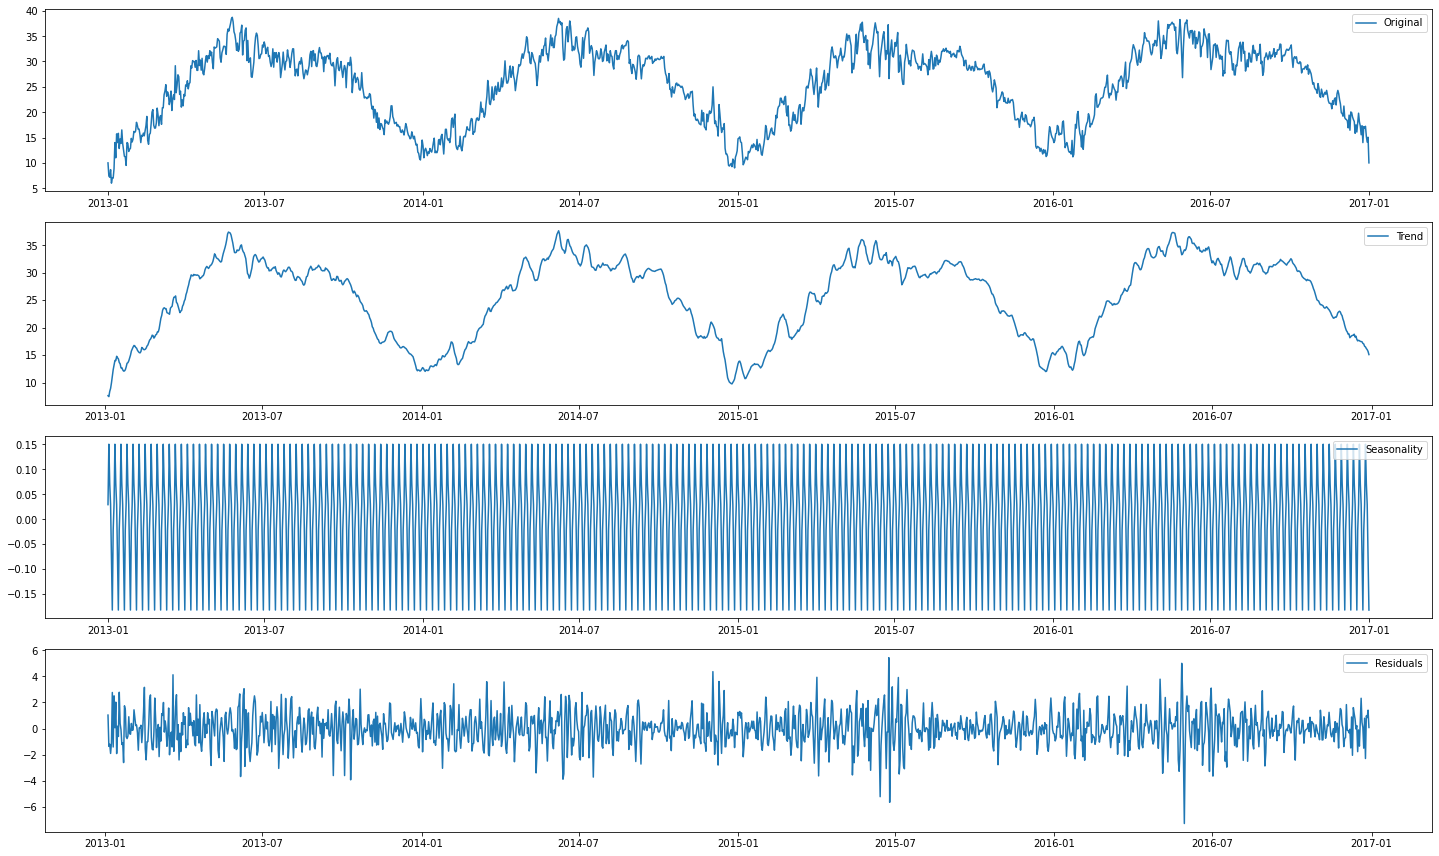

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(20,12))


plt.subplot(411)
plt.plot(time_train.index, time_train, label='Original')
plt.legend(loc='best')

# trend 
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# seasonal 
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

# residual
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

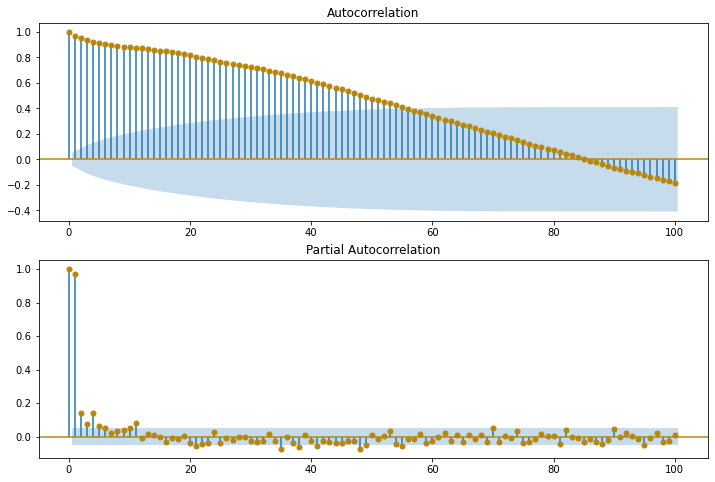

In [42]:

fig,ax = plt.subplots(2,1,figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(time_train, lags=100, ax=ax[0], color="darkgoldenrod")
fig = sm.graphics.tsa.plot_pacf(time_train, lags=100, ax=ax[1], color="darkgoldenrod")
plt.show()

# Forcating mean tempreture by ARIMA

In [70]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from itertools import product
p=range(0, 5)
d=0
q=range(0, 5)
parameters = product(p, q )
parameters_list = list(parameters)
len(parameters_list)

#model selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=ARIMA(time_train, order=(param[0], d, param[1]))
        model_fit= model.fit(disp=0)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model_fit.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model_fit.aic])


wrong parameters: (4, 4)


In [71]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.fit().summary())

   parameters          aic
19     (3, 4)  5513.239495
17     (3, 2)  5513.792140
8      (1, 3)  5548.704622
13     (2, 3)  5548.746376
9      (1, 4)  5549.102131
                              ARMA Model Results                              
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                     ARMA(3, 4)   Log Likelihood               -2747.620
Method:                       css-mle   S.D. of innovations              1.582
Date:                Fri, 30 Oct 2020   AIC                           5513.239
Time:                        08:06:29   BIC                           5560.828
Sample:                    01-01-2013   HQIC                          5530.991
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             25.2275      0.302    

error:  23.677793400268154


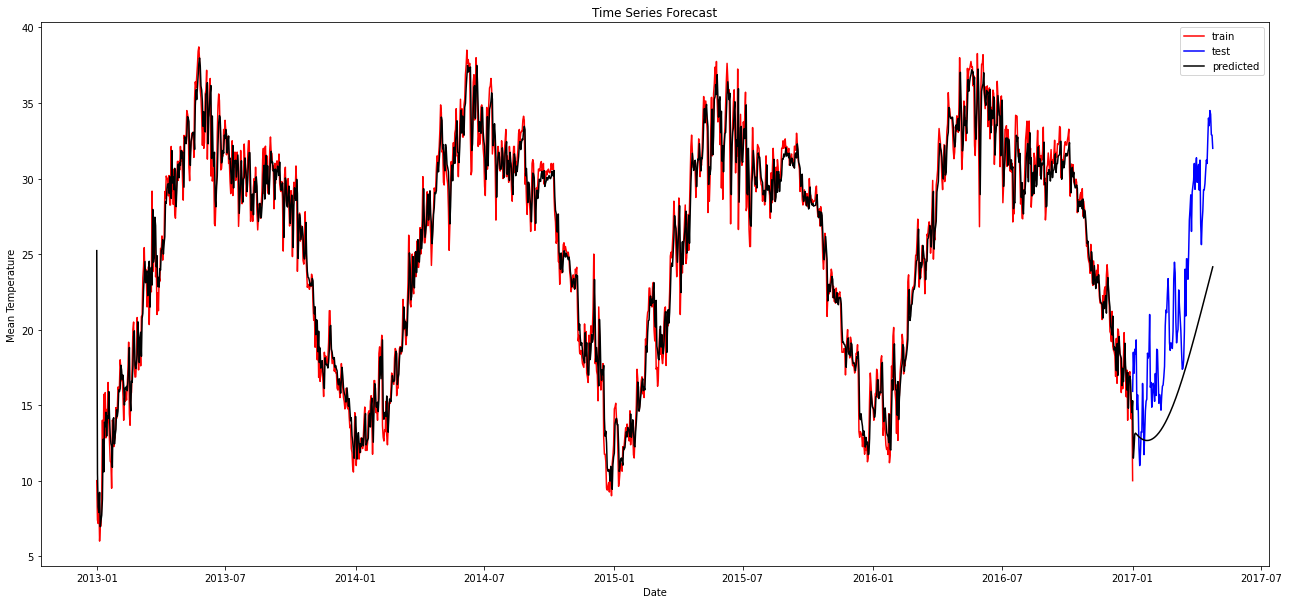

In [73]:


#predict 
start_index = datetime(2013, 1, 1)
end_index = datetime(2017, 4, 24)
forecast = best_model.fit(disp=0).predict(start=start_index, end=end_index)
forecast_test = best_model.fit(disp=0).predict(start=datetime(2017, 1, 1), end=end_index,  exog = time_test, dynamic=False)


def mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

print("error: " ,mape(time_test.meantemp, forecast_test))


#plot forcasted result
plt.figure(figsize=(22,10))
plt.plot(time_train.index, time_train.meantemp,color='red',label = "train")
plt.plot(time_test.index, time_test.meantemp,color='blue',label = "test")
plt.plot(forecast,color='black', label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()



<Figure size 1584x720 with 0 Axes>

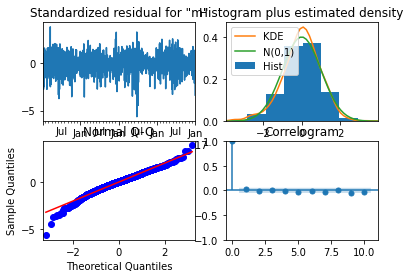

In [52]:
# check residual
plt.figure(figsize=(22,10))

plot = best_model.plot_diagnostics()

plt.show()

# Forcating mean tempreture by SARIMA

In [83]:
Qs = 2
qs = 2
Ps = 1
ps = 1
D=range(0, 3)
d=range(0, 3)
S=range(16, 25)
parameters = product(D, d, S)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(time_train, order=(Qs, param[0],qs), 
                                        seasonal_order=(Ps, param[1], ps,  param[2]),enforce_stationarity = False, 
    enforce_invertibility = False).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [84]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

    parameters          aic
71  (2, 1, 24)  5387.072956
61  (2, 0, 23)  5405.960074
44  (1, 1, 24)  5408.224651
17  (0, 1, 24)  5409.027925
31  (1, 0, 20)  5410.507578
                                      SARIMAX Results                                       
Dep. Variable:                             meantemp   No. Observations:                 1462
Model:             SARIMAX(2, 2, 2)x(1, 1, [1], 24)   Log Likelihood               -2686.536
Date:                              Fri, 30 Oct 2020   AIC                           5387.073
Time:                                      09:10:35   BIC                           5423.827
Sample:                                  01-01-2013   HQIC                          5400.808
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

error:  87.87063320253799


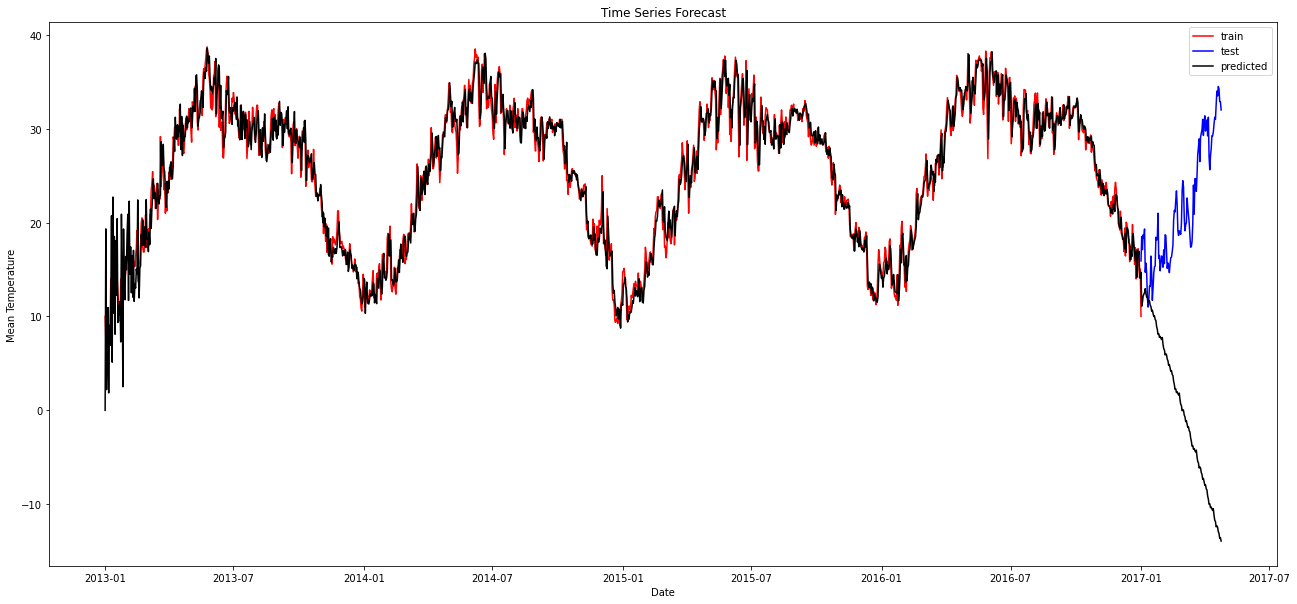

In [86]:

start_index = datetime(2013, 1, 1)
end_index = datetime(2017, 4, 24)
forecast = best_model.predict(start=start_index, end=end_index)
forecast_test = best_model.predict(start=datetime(2017, 1, 1), end=end_index,  exog = time_test, dynamic=False)



def mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

print("error: " ,mape(time_test.meantemp, forecast_test))


#plot forcasted result
plt.figure(figsize=(22,10))
plt.plot(time_train.index, time_train.meantemp,color='red',label = "train")
plt.plot(time_test.index, time_test.meantemp,color='blue',label = "test")
plt.plot(forecast,color='black', label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

<Figure size 1584x720 with 0 Axes>

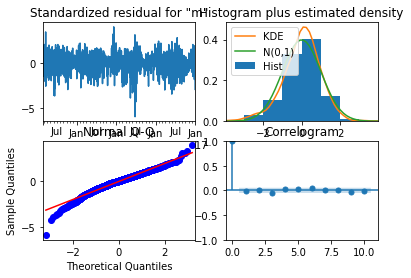

In [87]:
# check residual
plt.figure(figsize=(22,10))

plot = best_model.plot_diagnostics()

plt.show()

# Forcating mean tempreture by LSTM

In [88]:
training_set = time_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
print(training_set.shape)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
print(X_train.shape, y_train.shape)
X_train = np.reshape(X_train, (len(X_train), 1, 1))
print(X_train.shape)

(1462, 1)
(1461, 1) (1461, 1)
(1461, 1, 1)


In [89]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (None, 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, batch_size=5, epochs=30)

Epoch 1/30
293/293 [==============================] - 1s 5ms/step - loss: 123.2055
Epoch 2/30
293/293 [==============================] - 1s 5ms/step - loss: 3.8629
Epoch 3/30
293/293 [==============================] - 1s 5ms/step - loss: 3.3879
Epoch 4/30
293/293 [==============================] - 1s 5ms/step - loss: 3.4809
Epoch 5/30
293/293 [==============================] - 1s 5ms/step - loss: 3.1142
Epoch 6/30
293/293 [==============================] - 1s 5ms/step - loss: 3.1214
Epoch 7/30
293/293 [==============================] - 1s 5ms/step - loss: 3.1336
Epoch 8/30
293/293 [==============================] - 1s 5ms/step - loss: 3.2360
Epoch 9/30
293/293 [==============================] - 1s 5ms/step - loss: 3.1823
Epoch 10/30
293/293 [==============================] - 2s 5ms/step - loss: 3.1917
Epoch 11/30
293/293 [==============================] - 1s 5ms/step - loss: 3.0229
Epoch 12/30
293/293 [==============================] - 2s 5ms/step - loss: 3.1207
Epoch 13/30
293/293 [==

In [90]:
test_set = time_test.values[1:]
x_test = np.reshape(time_test.values[0:len(time_test)-1], (len(test_set), 1))
x_test = np.reshape(x_test, (len(x_test), 1, 1))
pred = model.predict(x_test)
pred = np.reshape(pred, (pred.shape[0], 1))

error:  [[4.47655558]]


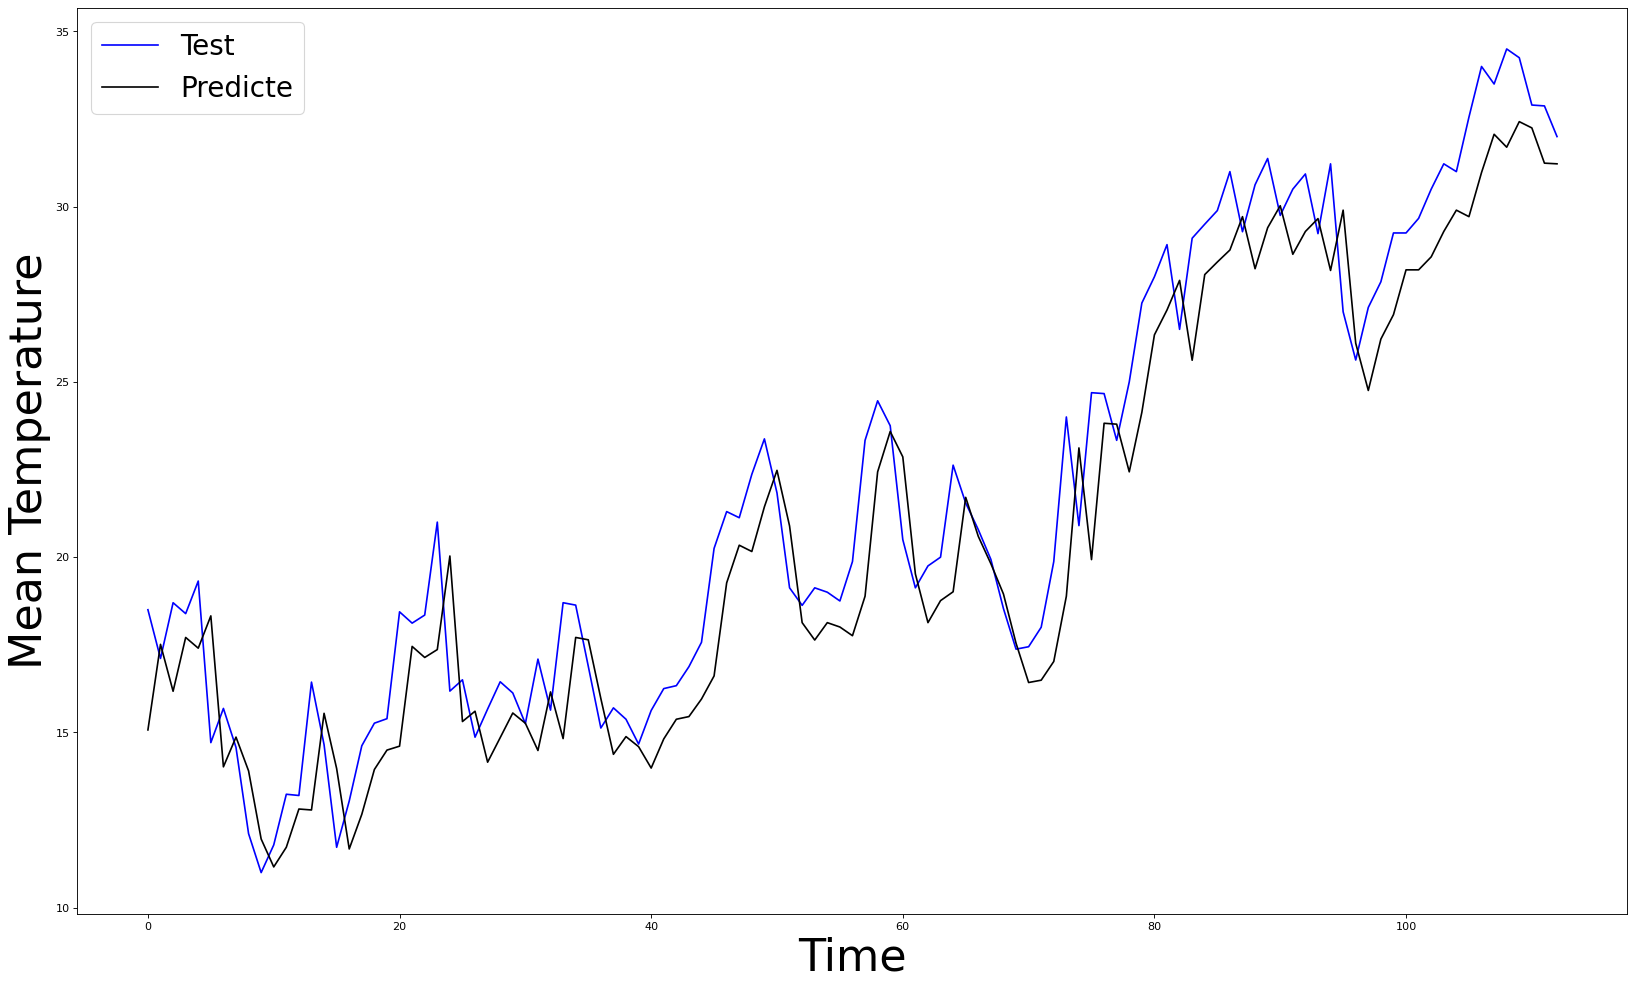

In [91]:




def mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

print("error: " ,mape(x_test, pred))

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'blue', label = 'Test')
plt.plot(pred, color = 'black', label = 'Predicte')

plt.xlabel('Time', fontsize=40)
plt.ylabel('Mean Temperature', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

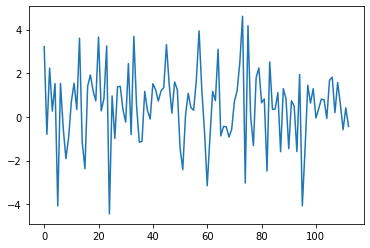

In [92]:
plt.plot(residual)

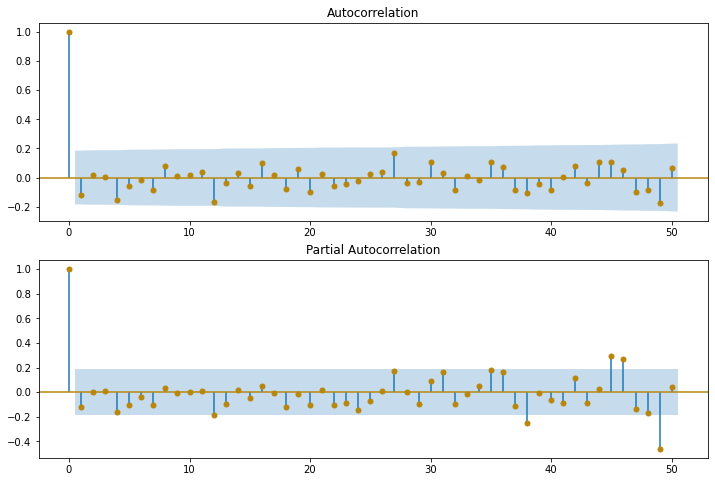

In [93]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(residual, lags=50, ax=ax[0], color="darkgoldenrod")
fig = sm.graphics.tsa.plot_pacf(residual, lags=50, ax=ax[1], color="darkgoldenrod")
plt.show()

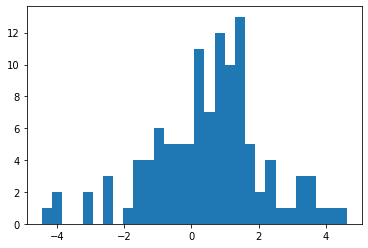

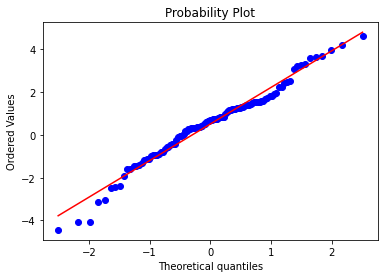

In [94]:
import scipy.stats as stats
def qqplot(dist):
    plt.hist(dist, bins=30)
    plt.show()
    stats.probplot(dist, dist="norm", plot=plt)
    plt.show()
qqplot(np.reshape(residual, (residual.shape[0])))